# Week 1: The global circulation
*MAQ - 32806, Chiel van Heerwaarden & Imme Benedict, 2017*

This is the first tutorial. In this tutorial, you will get used to the Jupyter Notebooks, and their work flow. In Jupyter notebooks you can write either text in Markdown format (including mathematics using LaTeX) or code in Python format. In this course, you will work on assignments that you are going to work out in your own notebook.
___

**SOME ESSENTIAL TIPS BEFORE STARTING!**

* Make a copy of the notebook via the `File` menu. By doing so, you always have the original file to revert to.
* Save your work often.
* In case of weird behavior, try to restart the notebook via the `Kernel` menu.
* Play around, the best way to find out how things work is to try them out!
* Use the internet for help on `numpy`, `matplotlib`, `cartopy` or `LaTeX` if you want to try something out.
* With `Shift+Enter` you can move down while executing cells.
* You can complete commands by pressing `Tab`.
___

# Setting up Python and load the data
We start the tutorial by loading the required Python packages and setting the figure properties.

In [1]:
# Loading the packages.
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import matplotlib.pyplot as plt # Matplotlib is a scientific plotting package.
import datetime                 # Datetime is a package to deal with dates.
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import LinearSegmentedColormap

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline
plt.rcParams.update({'font.size': 11})          # Set the standard font size of the plots to 11pt.
plt.rcParams.update({'figure.figsize': [13,5]}) # Set the standard figure size.

In [2]:
# Create custom color map similar to the NCAR NCL WhiteBlueGreenYellowRed
cdict = {'red':   ((   0/253., 255./255., 255./255.),
                   (  36/253., 157./255., 157./255.),
                   (  72/253.,  72./255.,  72./255.),
                   ( 108/253.,  73./255.,  73./255.),
                   ( 145/253., 250./255., 250./255.),
                   ( 181/253., 245./255., 245./255.),
                   ( 217/253., 211./255., 211./255.),
                   ( 253/253., 146./255., 146./255.)),
         'green': ((   0/253., 255./255., 255./255.),
                   (  36/253., 218./255., 218./255.),
                   (  72/253., 142./255., 142./255.),
                   ( 108/253., 181./255., 181./255.),
                   ( 145/253., 232./255., 232./255.),
                   ( 181/253., 106./255., 106./255.),
                   ( 217/253.,  31./255.,  31./255.),
                   ( 253/253.,  21./255.,  21./255.)),
         'blue':  ((   0/253., 255./255., 255./255.),
                   (  36/253., 247./255., 247./255.),
                   (  72/253., 202./255., 202./255.),
                   ( 108/253.,  70./255.,  70./255.),
                   ( 145/253.,  92./255.,  92./255.),
                   ( 181/253.,  45./255.,  45./255.),
                   ( 217/253.,  40./255.,  40./255.),
                   ( 253/253.,  25./255.,  25./255.))}

my_cmap = LinearSegmentedColormap('my_colormap', cdict,256)

___
Now, you load the data and read out the desired variables from a NetCDF file from the ECMWF ERA-Interim data archive. You are loading a file with data from October 1st, 2015.

In [3]:
# Loading the data into the variables.
nc_file = nc.Dataset("era_data.nc", "r")
lat = nc_file.variables["latitude"][:]
lon = nc_file.variables["longitude"][:]
p = nc_file.variables["level"][:]*100.  # Conversion of pressure to Pa.

t = 0 # We only load the first time index from the data.
time = nc.num2date(nc_file.variables["time"][t], nc_file.variables["time"].units)
print("The time is: {}".format(time))

# With the code below, we roll the map, to get the 0 meridian,
# rather than the Pacific in the middle.
nroll = lon.size//2
lon = np.roll(lon, nroll)
lon = np.where(lon>=180., lon-360., lon)

# We load 3D fields of the two horizontal wind components, the geopotential and the temperature.
u     = np.roll(nc_file.variables["u"][t,:,:,:], nroll, -1)
v     = np.roll(nc_file.variables["v"][t,:,:,:], nroll, -1)
omega = np.roll(nc_file.variables["w"][t,:,:,:], nroll, -1)
Phi   = np.roll(nc_file.variables["z"][t,:,:,:], nroll, -1)
T     = np.roll(nc_file.variables["t"][t,:,:,:], nroll, -1)

nc_file.close() # The file access is closed as no further data is needed now.

The time is: 2016-01-01 03:00:00


This is it. With the actions below, you have done everything to be able to work with ECMWF ERA-Interim weather data.
___

# Working with numpy
Before plotting the data, we have a quick look at the shape of the loaded data. Our 3D fields have three dimensions: `height`, `lat` and `lon` from which we can select the desired fields. Pressure is the height coordinate of our data. Below we show some simple examples.

In [4]:
print(Phi.shape)     # We have 37 height levels, 241 latitudes and 480 longitudes.
print(p[0])          # Our lowest pressure level is 1000 hPa.
print(p[6])          # At level 6 we find 850 hPa.
Phi_850 = Phi[6,:,:] # We create a new variable that contains only the geopotential height at 850 hPa.
print(Phi_850.shape) # The new data has only two dimensions, lat and lon.

# We can also write formatted output to the screen.
print("The standard deviation is {0}".format(np.std(Phi_850))) # We can format the output.
print("The mean, min and max are {0}, {1}, {2}".format(np.mean(Phi_850), np.min(Phi_850), np.max(Phi_850)))
print("The mean, min and max are {0:.0f}, {1:.1f}, {2:.2f}".format(np.mean(Phi_850), np.min(Phi_850), np.max(Phi_850)))

(37, 241, 480)
100000.0
85000.0
(241, 480)
The standard deviation is 1587.8661158560112
The mean, min and max are 13561.70812564149, 9429.24728703004, 16474.802276500996
The mean, min and max are 13562, 9429.2, 16474.80


# Plotting and manipulating data
## Plotting a world map
We are now going to plot the temperature $T$ and geopotential $\Phi$ at 500 hPa. Note that our units are SI.

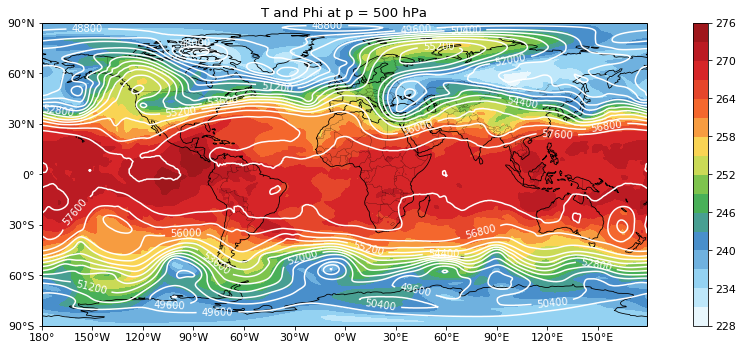

In [5]:
p_plot = 50000. # Choose the height in pressure level at which you want to plot.
n = abs(p-p_plot).argmin() # This is a trick to find the index closest to the desired value.

my_projection = ccrs.PlateCarree(central_longitude=0)

fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)

ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

cb = ax1.contourf(lon, lat, T[n,:,:], 15, cmap=my_cmap) # We plot a colormesh using the gist_ncar colormap.
fig1.colorbar(cb) # We add a colorbar to show the values of temperature.
cz = ax1.contour(lon, lat, Phi[n,:,:], 15, colors='w', linewidths=1.5) # We plot the geopotential in contours.
ax1.clabel(cz, fmt='%1.0f', fontsize=10.) # We add labels to the contour lines.
ax1.set_title('T and Phi at p = {0:.0f} hPa'.format(p[n]/100.)); # We add a title to the plot. 
fig1.tight_layout() # With this function we make the figure fit as good as possible.

## Plotting vertical profiles
It is also possible to make simple line plots. Below we plot the temperature profile in Wageningen.

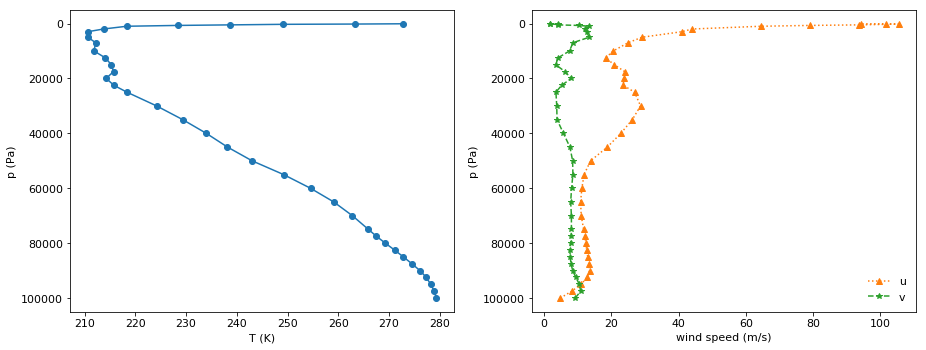

In [6]:
lat_plot = 51.97
lon_plot = 5.67
i_lon = abs(lon - lon_plot).argmin()
j_lat = abs(lat - lat_plot).argmin()

fig = plt.figure()
ax1 = plt.subplot(121)
ax1.plot(T[:,j_lat,i_lon], p, 'C0o-')
ax1.set_xlabel('T (K)')
ax1.set_ylabel('p (Pa)')
ax1.invert_yaxis()

ax2 = plt.subplot(122)
ax2.plot(u[:,j_lat,i_lon], p, 'C1^:' , label='u')
ax2.plot(v[:,j_lat,i_lon], p, 'C2*--', label='v')
ax2.set_xlabel('wind speed (m/s)')
ax2.set_ylabel('p (Pa)')
ax2.legend(loc=0, frameon=False)
ax2.invert_yaxis()
fig.tight_layout()


## Manipulating data
In Python, the underlying language of the notebooks, it is very easy to do manipulations on the data. Below, we calculate the 3D field of total wind speed and plot it. Again, we plot the data on the previously defined index of the 500 hPa level `n`. We calculate the total wind speed $U$ as
$$ U = \sqrt{u^2 + v^2} $$

The equation above has been rendered using $\LaTeX$, which is very useful for typesetting equations.

In [7]:
U = (u**2 + v**2)**.5

Below, we set the range of the map and choose again the level that we plot the data at.

In [8]:
lat_start = 10
lat_end = 80
lon_start = -100
lon_end = 50

p_plot = 50000. # Choose the height in pressure level at which you want to plot.
n = abs(p-p_plot).argmin() # This is a trick to find the index closest to the desired value.

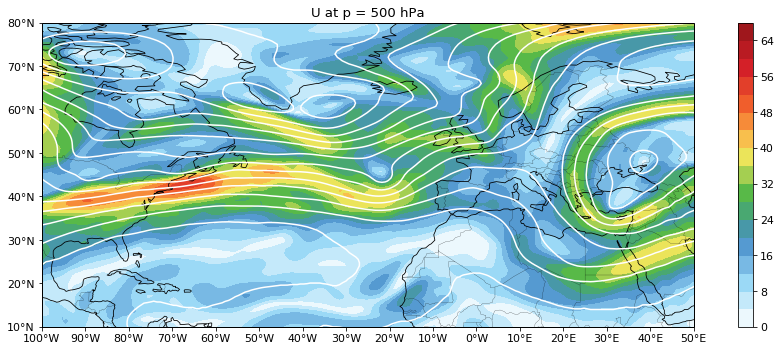

In [9]:
# Plot the wind at 500 hPA
fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)

ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax1.set_xticks(np.arange(-180, 181, 10), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

cb = ax1.contourf(lon, lat, U[n,:,:], 21, cmap=my_cmap)
fig1.colorbar(cb)
ax1.contour(lon, lat, Phi[n,:,:], 15, colors='w', linewidths=1.5)
ax1.set_xlim(lon_start, lon_end)
ax1.set_ylim(lat_start, lat_end)
ax1.set_title('U at p = {0:.0f} hPa'.format(p[n]/100.));
fig1.tight_layout()

___
The `numpy` package provides function for averaging arrays over a chosen axis. Below we calculate and plot the vertical profile of zonal mean temperature.

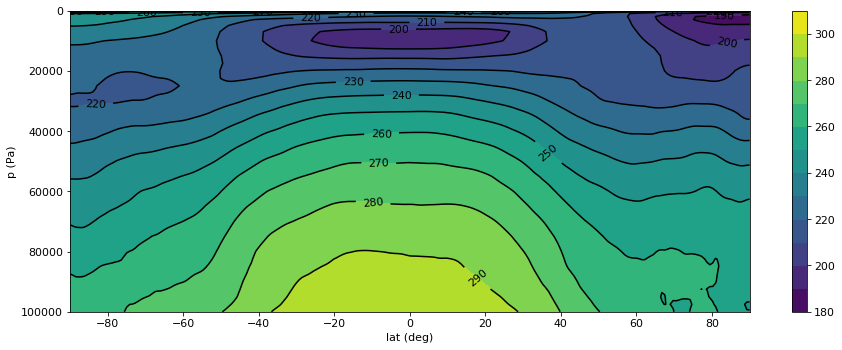

In [10]:
T_zonal_mean = np.mean(T, axis=2)     # Compute the mean over the longitude axis.
# T_zonal_mean = T.mean(axis=2) # This is the same as above, but in the object-oriented way.
T_contours = np.arange(180, 320, 10)  # Define the contour levels.

fig1 = plt.figure()
ax1 = plt.subplot(111)
cb = ax1.contourf(lat, p, T_zonal_mean, T_contours)
fig1.colorbar(cb)
cl = ax1.contour(lat, p, T_zonal_mean, T_contours, colors='k')
ax1.clabel(cl, fmt="%.0f") # We state here that the number has zero decimal numbers.
ax1.invert_yaxis()
ax1.set_xlabel('lat (deg)')
ax1.set_ylabel('p (Pa)')
ax1.set_xlim(-90, 90)
ax1.set_ylim(1e5, 0)
fig1.tight_layout()

**A WORD OF WARNING**

The `axis=` specification can be quite confusing. The field `T[:,:,:]` has three dimensions. The first (`axis=0`) is the height in pressure levels, the second (`axis=1`) is the latitude and the third (`axis=2`) is the longitude. The field `T[0,:,:]`, however, has only two dimensions, because the height disappears as soon as we select one level. This means that the axis that corresponds to latitude is `axis=0`, and longitude is `axis=1`. The Python code below illustrates this.

In [11]:
print('The shape of T[:,:,:] is {0}'.format(T[:,:,:].shape))
print('The length of axis=0 is {0}'.format(T[:,:,:].shape[0]))
print('The shape of T[0,:,:] is {0}'.format(T[0,:,:].shape))
print('The length of axis=0 is {0}'.format(T[0,:,:].shape[0]))

The shape of T[:,:,:] is (37, 241, 480)
The length of axis=0 is 37
The shape of T[0,:,:] is (241, 480)
The length of axis=0 is 241


## Computing differential operators
With the example below, you can calculate the gradient of the geopotential in the zonal and meridional direction. This is a tricky example that needs to be studied with care. In spherical coordinates, the two horizontal components of the gradient of the geopotential $\nabla\Phi$ are

$$
\dfrac{\partial \Phi}{\partial x} = \dfrac{1}{a \cos \phi} \dfrac{\partial \Phi}{\partial \lambda},\\
\dfrac{\partial \Phi}{\partial y} = \dfrac{1}{a} \dfrac{\partial \Phi}{\partial \phi},
$$

where $a$ is the radius of the earth, $\phi$ the latitude and $\lambda$ the longitude.
With `numpy`, these terms can be computed using the `np.gradient` function. This function applies centered finite differences and assumes that the distance between nodes is equal to unity. Therefore, the gradients needs to be computed as

$$
\dfrac{\partial \Phi}{\partial x} \approx \dfrac{1}{a \cos \phi} \dfrac{\delta \Phi}{\delta \lambda} =  \dfrac{1}{a \cos \phi} \dfrac{\dfrac{\delta \Phi}{\delta i}}{\dfrac{\delta \lambda}{\delta i}}.
$$

In the computation of the gradients, we have arrays of different dimensions. $\Phi$ is three-dimensional, but $\lambda$ and $\phi$ are one-dimensional. Fortunately, `numpy` provides a trick to make $\lambda$ and $\phi$ pretend to be three-dimensional like the geopotential $\Phi$ array. With the `newaxis` keyword, we can add an additional axis that takes automatically the correct values.

In [12]:
a_earth = 6.37e6 # Here, we define the radius of the earth.

# Two arrays of zeros are initialized with the same shape as that of Z.
dPhidx = np.zeros(Phi.shape)
dPhidy = np.zeros(Phi.shape)

latrad = np.deg2rad(lat)
lonrad = np.deg2rad(lon)

# We initialize an array with the cosine of the latitude.
cos_lat = np.cos(latrad)

# With \ it is possible to break a long line. Carefully study the use of the newaxis keyword.
dPhidx[:,:,:] = (a_earth*cos_lat[np.newaxis,:,np.newaxis])**(-1) \
              * np.gradient(Phi, axis=2) / np.gradient(lonrad[np.newaxis, np.newaxis, :], axis=2)
dPhidy[:,:,:] = (a_earth)**(-1) \
              * np.gradient(Phi, axis=1) / np.gradient(latrad[np.newaxis, :, np.newaxis], axis=1)

In the map below, we no longer choose a number of intervals in the `contourf`, but instead, we manually fix the range. This gives us more control, and it also allows us to use the same scaling for multiple plots. With `np.linspace`, we can specify the start of the interval, the end, and the number of steps.

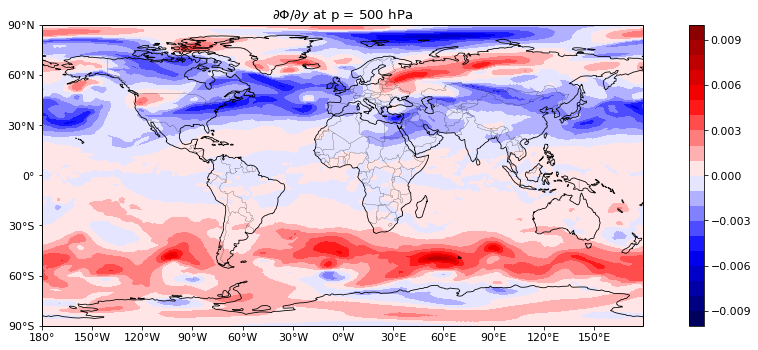

In [13]:
# World map of latitudinal temperature gradients.
fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

dPhidy_range = np.linspace(-0.01, 0.01, 21)

cb = ax1.contourf(lon, lat, dPhidy[n,:,:], dPhidy_range, cmap=plt.cm.seismic)
fig1.colorbar(cb)
#ax1.contour(lon, lat, Phi[n,:,:], 15, colors='k', linewidths=1.5)
ax1.set_title('$\partial \Phi/\partial y$ at p = {0:.0f} hPa'.format(p[n]/100));
fig1.tight_layout()

___
In a similar fashion, it is possible to compute vertical gradients. Note that your data is in pressure coordinates. Vertical gradients will therefore expressed in a change per unit of Pascal. In the example below, we calculate the vertical gradient of temperature

$$ \dfrac{\partial T}{\partial p} \approx \dfrac{\delta T}{\delta p} = \dfrac{\dfrac{\delta T}{\delta k}}{\dfrac{\delta p}{\delta k}}.$$

We plot the data again at the previously chosen height. Our pressure levels are only a one-dimensional array, but with the `newaxis` keyword, we can again add an additional axis that takes automatically the correct values.

For maps with a lot of detail, `contourf` can take very long to plot the contour lines. In that case, it is possible to use `pcolormesh` instead. This function does not use contour lines, but just colors the pixels. You can control the range with the `vmin` and `vmax` keyword arguments.

In [14]:
dTdp = np.gradient(T[:,:,:], axis=0) / np.gradient(p[:, np.newaxis, np.newaxis], axis=0)

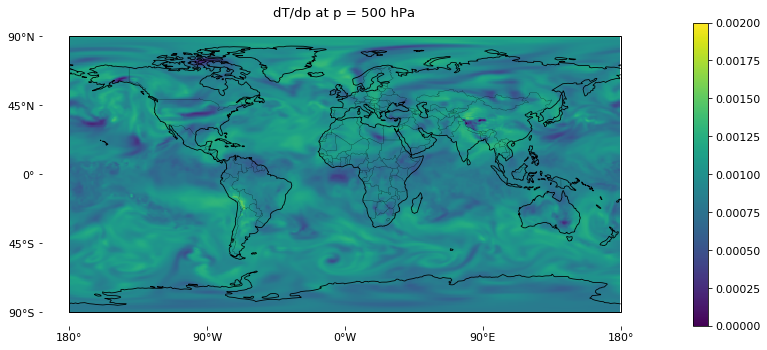

In [15]:
fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)

ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.set_xticks(np.linspace(-180, 180, 5), crs=my_projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

cb = ax1.pcolormesh(lon, lat, dTdp[n,:,:], vmin=0, vmax=0.002, cmap=plt.cm.viridis)
fig1.colorbar(cb)
#ax1.contour(lon, lat, Phi[n,:,:], 15, colors='w', linewidths=1.5)
ax1.set_title('dT/dp at p = {0:.0f} hPa'.format(p[n]/100.));
fig1.tight_layout()

___
# Exercises
We have reached the end of the examples. Now it is time to start developing the skills you need in the coming weeks. Below you find a set of exercises that will help you in that.
___
## Exercise 1
1. Plot maps of total wind at 850 hPa and 300 hPa, and add contour lines of the geopotential.
2. Describe the most prominent differences. You do not have to explain the underlying physics yet in detail. What are the differences between the Northern and Southern hemisphere?  
3. Plot the temperature at 300 hPa and add contour lines of the geopotential.
4. What is the connection between the wind plot and the temperature plot at 300 hPa?
___
## Exercise 2
1. Calculate and plot the zonal gradient in geopotential height at 500 hPa.
2. Calculate and plot the meridional gradient in geopotential height at 500 hPa.
3. Calculate and plot the magnitude of the horizontal gradient vector.
$\nabla_h \Phi \equiv \left(\dfrac{\partial \Phi}{\partial x}, \dfrac{\partial \Phi}{\partial y}, 0 \right)$
4. Where to the largest gradients occur? Discuss the differences between the tropics, the midlatitudes, and the poles.
___
## Exercise 3
1. Calculate the 3D field of potential temperature $\theta \equiv T \left( \dfrac{p_0}{p} \right)^{R_d/c_p}$
2. Calculate and plot the vertical cross section of zonal mean potential temperature.
3. Calculate the zonal mean zonal wind and add it to the previous plot. 
4. Discuss the plot. Explain where do the largest meridional gradients and wind speeds occur? Do you see jetstreams? Where are they positioned? What is the dominant wind direction on earth?
___
## Exercise 4
1. Calculate all terms of the conservation of mass equation in pressure coordinates $\dfrac{\partial u}{\partial x} + \dfrac{\partial v}{\partial y} + \dfrac{\partial \omega}{\partial p}$ and check whether they add to zero.
2. Calculate the horizontal divergence at 300 hPa and reduce the map areas to the limits used in the examples above. Add the contour lines of the geopotential as well.
___
## Exercise 5
1. Calculate (only in math, either on paper or in the notebook using $\LaTeX$) the cross product of the nabla operator and the wind vector $\omega = \nabla \times \boldsymbol{U}$ and explain the meaning of $\omega$.
2. Calculate (only in math, either on paper or in the notebook using $\LaTeX$) $\zeta = \boldsymbol{k} \cdot \left( \nabla \times \boldsymbol{U} \right)$ and explain the meaning of $\zeta$.
3. Calculate and plot $\zeta$ at the 500 hPa level, again within the same map limits as in exercise 4 and add the contour lines.
4. Describe the observed horizontal vorticity. What is the link between the observed vorticity and the geopotential? In which two ways can you produce vorticity? Can you find both in the map?
___
## Exercise 6
1. Plot a vertical cross section of potential temperature with `lon` on the horizontal axis and `p` on the vertical axis at 55 S. Add contour lines of meridional velocity $v$.
2. What do you observe? Can you identify the weather systems over the Southern oceans that you observed in other maps?
3. Create an $xy$-plot with `lon` $\lambda$ on the horizontal axis and meridional velocity on the vertical axis at 500 hPa at 55S. How many weather systems do you identify?

___
Work out the exercises below here.
___

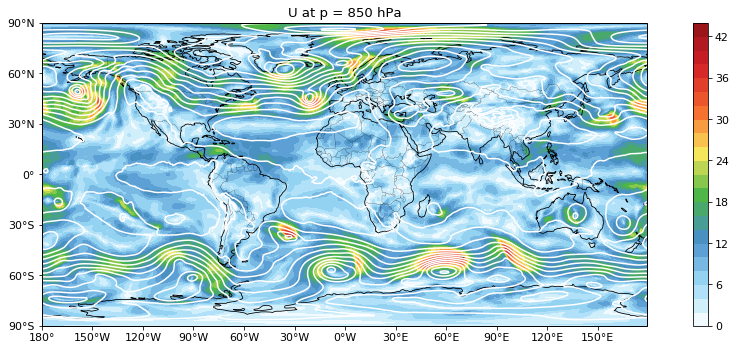

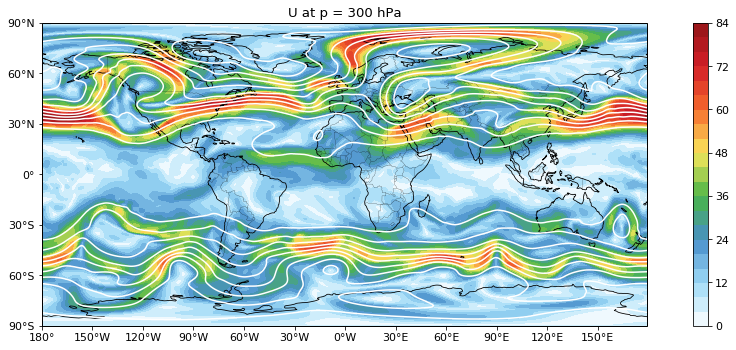

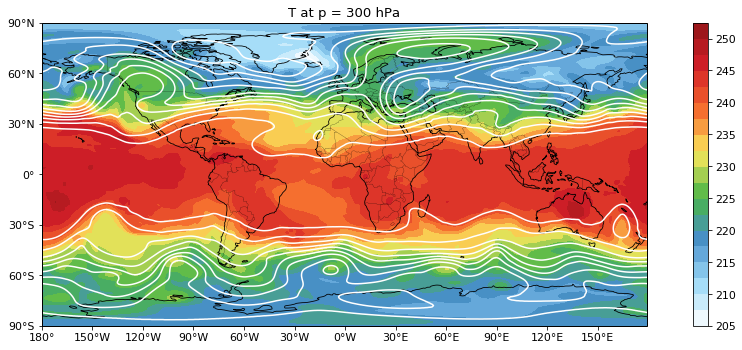

In [16]:
# Plots exercise 1.
# 850 hPa.
p_plot = 85000. # Choose the height in pressure level at which you want to plot.
n = abs(p-p_plot).argmin() # This is a trick to find the index closest to the desired value.

fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)

ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

cb = ax1.contourf(lon, lat, U[n,:,:], 21, cmap=my_cmap)
fig1.colorbar(cb)
ax1.contour(lon, lat, Phi[n,:,:], 15, colors='w', linewidths=1.5)
ax1.set_title('U at p = {0:.0f} hPa'.format(p[n]/100.));
fig1.tight_layout()

# 300 hPa
p_plot = 30000. # Choose the height in pressure level at which you want to plot.
n = abs(p-p_plot).argmin() # This is a trick to find the index closest to the desired value.

fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)

ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

cb = ax1.contourf(lon, lat, U[n,:,:], 21, cmap=my_cmap)
fig1.colorbar(cb)
ax1.contour(lon, lat, Phi[n,:,:], 15, colors='w', linewidths=1.5)
ax1.set_title('U at p = {0:.0f} hPa'.format(p[n]/100.));
fig1.tight_layout()


fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)

ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

cb = ax1.contourf(lon, lat, T[n,:,:], 21, cmap=my_cmap)
fig1.colorbar(cb)
ax1.contour(lon, lat, Phi[n,:,:], 15, colors='w', linewidths=1.5)
ax1.set_title('T at p = {0:.0f} hPa'.format(p[n]/100.));
fig1.tight_layout()

In [17]:
grad_Phi_mag = (dPhidx**2 + dPhidy**2)**.5

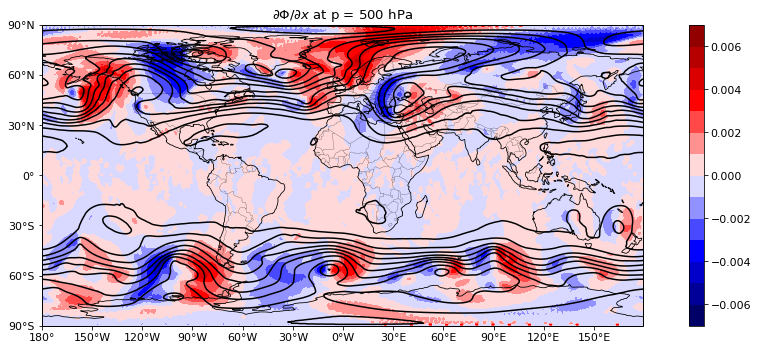

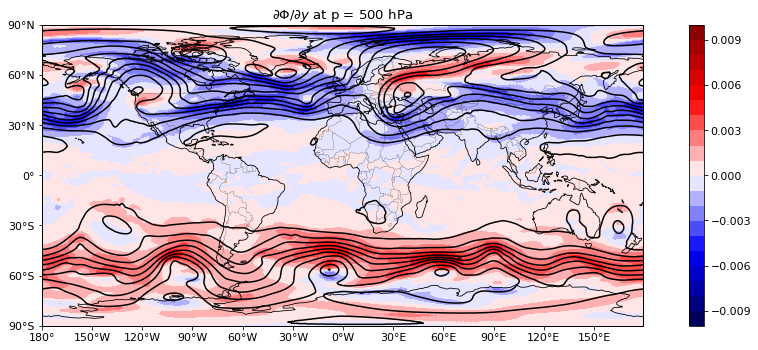

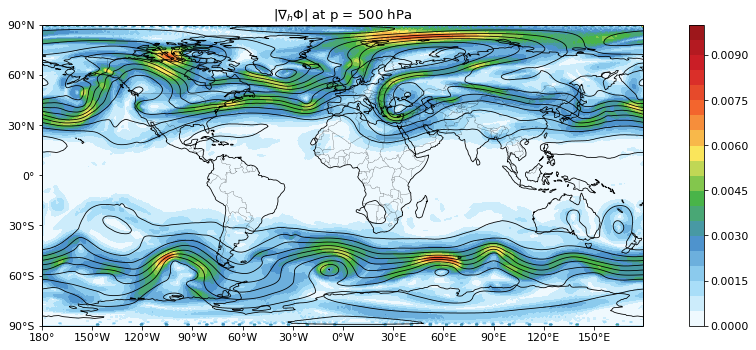

In [18]:
# Plots exercise 2.
p_plot = 50000. # Choose the height in pressure level at which you want to plot.
n = abs(p-p_plot).argmin() # This is a trick to find the index closest to the desired value.

# World map of latitudinal temperature gradients.
fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

dPhidx_range = np.linspace(-0.007, 0.007, 15)

cb = ax1.contourf(lon, lat, dPhidx[n,:,:], dPhidx_range, cmap=plt.cm.seismic)
fig1.colorbar(cb)
ax1.contour(lon, lat, Phi[n,:,:], 11, colors='k', linewidths=1.5)
ax1.set_title('$\partial \Phi/\partial x$ at p = {0:.0f} hPa'.format(p[n]/100));
fig1.tight_layout()

# World map of latitudinal temperature gradients.
fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

dPhidy_range = np.linspace(-0.01, 0.01, 21)

cb = ax1.contourf(lon, lat, dPhidy[n,:,:], dPhidy_range, cmap=plt.cm.seismic)
fig1.colorbar(cb)
ax1.contour(lon, lat, Phi[n,:,:], 11, colors='k', linewidths=1.5)
ax1.set_title('$\partial \Phi/\partial y$ at p = {0:.0f} hPa'.format(p[n]/100));
fig1.tight_layout()

# World map of latitudinal temperature gradients.
fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

grad_Phi_range = np.linspace(0., 0.01, 21)

cb = ax1.contourf(lon, lat, grad_Phi_mag[n,:,:], grad_Phi_range, cmap=my_cmap)
fig1.colorbar(cb)
ax1.contour(lon, lat, Phi[n,:,:], 11, colors='k', linewidths=0.8)
ax1.set_title(r'$\left\| \nabla_h \Phi \right\|$ at p = {0:.0f} hPa'.format(p[n]/100));
fig1.tight_layout()

In [19]:
dTdx = (a_earth*cos_lat[np.newaxis,:,np.newaxis])**(-1) \
     * np.gradient(T, axis=2) / np.gradient(lonrad[np.newaxis, np.newaxis, :], axis=2)
dTdy = (a_earth)**(-1) \
     * np.gradient(T, axis=1) / np.gradient(latrad[np.newaxis, :, np.newaxis], axis=1)
dT = (dTdx**2 + dTdy**2)**0.5

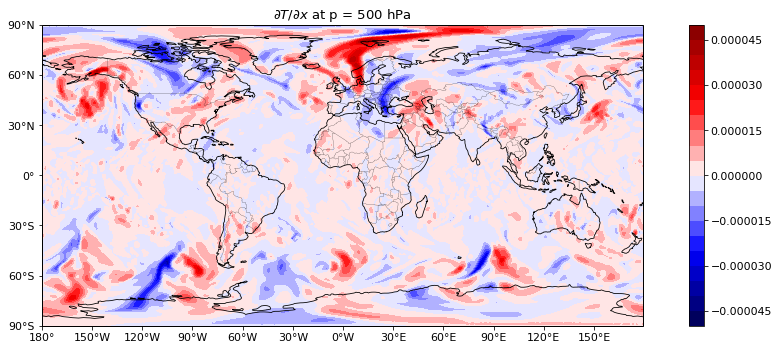

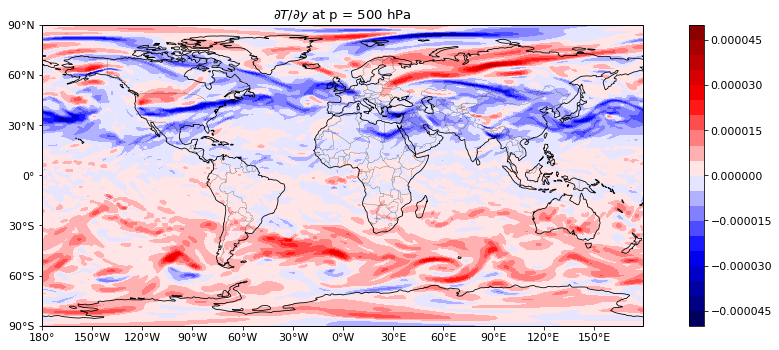

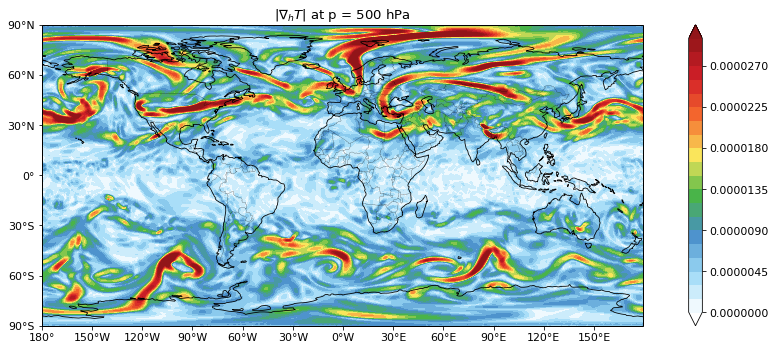

In [20]:
# Additional plots exercise 2.
p_plot = 50000. # Choose the height in pressure level at which you want to plot.
n = abs(p-p_plot).argmin() # This is a trick to find the index closest to the desired value.

# World map of latitudinal temperature gradients.
fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

dT_range = np.linspace(-5e-5, 5e-5, 21)

cb = ax1.contourf(lon, lat, dTdx[n,:,:], dT_range, cmap=plt.cm.seismic)
fig1.colorbar(cb)
#ax1.contour(lon, lat, Phi[n,:,:], 15, colors='k', linewidths=1.5)
ax1.set_title('$\partial T/\partial x$ at p = {0:.0f} hPa'.format(p[n]/100));
fig1.tight_layout()

# World map of latitudinal temperature gradients.
fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

cb = ax1.contourf(lon, lat, dTdy[n,:,:], dT_range, cmap=plt.cm.seismic)
fig1.colorbar(cb)
#ax1.contour(lon, lat, Phi[n,:,:], 15, colors='k', linewidths=1.5)
ax1.set_title('$\partial T/\partial y$ at p = {0:.0f} hPa'.format(p[n]/100));
fig1.tight_layout()

# World map of latitudinal temperature gradients.
fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

dT_range = np.linspace(0, 3e-5, 21)


cb = ax1.contourf(lon, lat, dT[n,:,:], dT_range, cmap=my_cmap, extend='both')
fig1.colorbar(cb)
#ax1.contour(lon, lat, Phi[n,:,:], 15, colors='k', linewidths=1.5)
ax1.set_title(r'$\left\| \nabla_h T \right\|$ at p = {0:.0f} hPa'.format(p[n]/100));
fig1.tight_layout()

In [21]:
Rdcp = 287./1005.
theta = T*(1.e5/p[:,np.newaxis,np.newaxis])**(Rdcp)
theta_zonal_mean = theta.mean(axis=2)
u_zonal_mean = u.mean(axis=2)

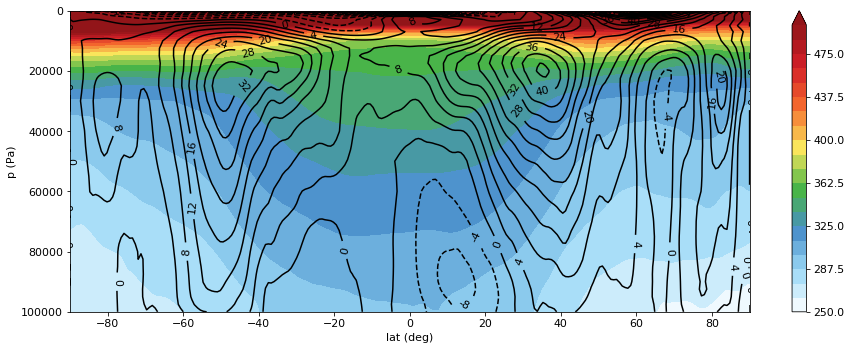

In [22]:
# Plots exercise 3.
theta_range = np.linspace(250, 500, 21)
fig1 = plt.figure()
ax1 = plt.subplot(111)
cb = ax1.contourf(lat, p, theta_zonal_mean, theta_range, cmap=my_cmap, extend="max")
fig1.colorbar(cb)
u_range = np.arange(-100, 100, 4.)
cl = ax1.contour(lat, p, u_zonal_mean, u_range, colors='k')
ax1.clabel(cl, fmt="%.0f")
ax1.invert_yaxis()
ax1.set_xlabel('lat (deg)')
ax1.set_ylabel('p (Pa)')
ax1.set_xlim(-90, 90)
ax1.set_ylim(1e5, 0)
fig1.tight_layout()

In [23]:
dudx = (a_earth*cos_lat[np.newaxis,:,np.newaxis])**(-1) \
     * np.gradient(u, axis=2) / np.gradient(lonrad[np.newaxis, np.newaxis, :], axis=2)
dvdy = (a_earth)**(-1) \
     * np.gradient(v, axis=1) / np.gradient(latrad[np.newaxis, :, np.newaxis], axis=1)
domegadp = np.gradient(omega[:,:,:], axis=0) / np.gradient(p[:, np.newaxis, np.newaxis], axis=0)

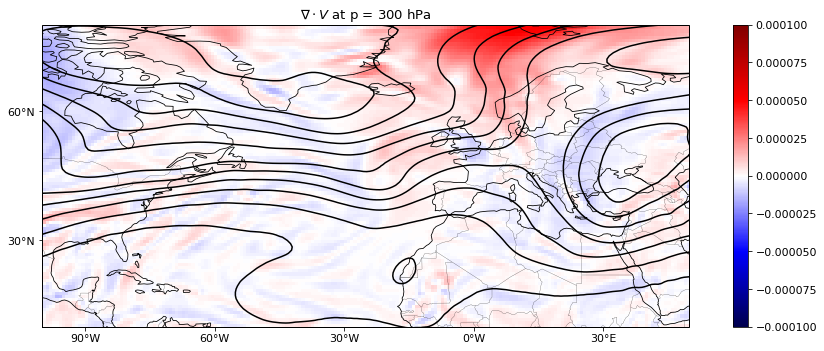

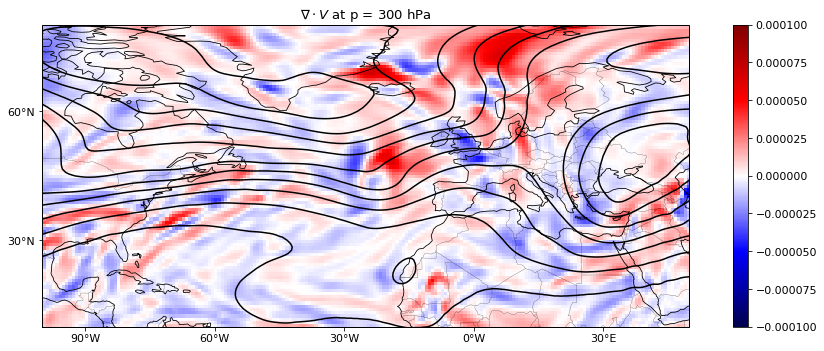

In [24]:
# Plots exercise 4.
p_plot = 30000. # Choose the height in pressure level at which you want to plot.
n = abs(p-p_plot).argmin() # This is a trick to find the index closest to the desired value.

fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_xlim(lon_start, lon_end)
ax1.set_ylim(lat_start, lat_end)

cb = ax1.pcolormesh(lon, lat, dudx[n,:,:]+dvdy[n,:,:]+domegadp[n,:,:],  vmin=-1e-4, vmax=1e-4, cmap=plt.cm.seismic) 
fig1.colorbar(cb)
ax1.contour(lon, lat, Phi[n,:,:], 15, colors='k', linewidths=1.5)
ax1.set_title(r'$\nabla \cdot V$ at p = {0:.0f} hPa'.format(p[n]/100));
fig1.tight_layout()

fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_xlim(lon_start, lon_end)
ax1.set_ylim(lat_start, lat_end)

cb = ax1.pcolormesh(lon, lat, dudx[n,:,:]+dvdy[n,:,:], vmin=-1e-4, vmax=1e-4, cmap=plt.cm.seismic) 
fig1.colorbar(cb)
ax1.contour(lon, lat, Phi[n,:,:], 15, colors='k', linewidths=1.5)
ax1.set_title(r'$\nabla \cdot V$ at p = {0:.0f} hPa'.format(p[n]/100));
fig1.tight_layout()

In [25]:
zeta = np.zeros_like(u)
zeta += (a_earth*cos_lat[np.newaxis,:,np.newaxis])**(-1) \
      * np.gradient(v, axis=2) / np.gradient(lonrad[np.newaxis, np.newaxis, :], axis=2)
zeta -= (a_earth)**(-1) \
      * np.gradient(u, axis=1) / np.gradient(latrad[np.newaxis, :, np.newaxis], axis=1)

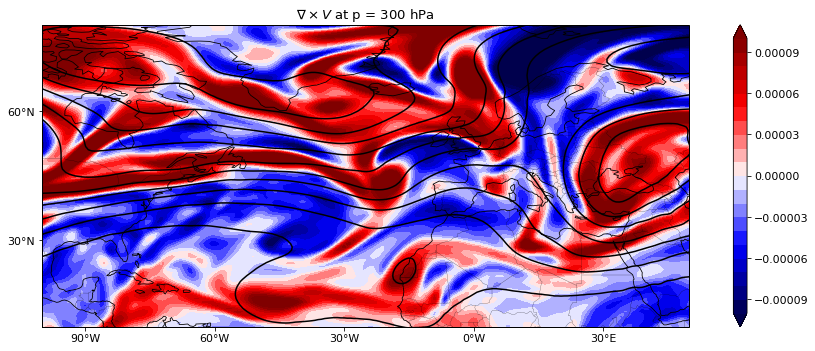

In [26]:
# Plot exercise 5.
p_plot = 30000. # Choose the height in pressure level at which you want to plot.
n = abs(p-p_plot).argmin() # This is a trick to find the index closest to the desired value.

fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
ax1.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_xlim(lon_start, lon_end)
ax1.set_ylim(lat_start, lat_end)

zeta_range = np.linspace(-1e-4, 1e-4, 21)
cb = ax1.contourf(lon, lat, zeta[n,:,:], zeta_range, cmap=plt.cm.seismic, extend='both') 
fig1.colorbar(cb)
ax1.contour(lon, lat, Phi[n,:,:], 15, colors='k', linewidths=1.5)
ax1.set_title(r'$\nabla \times V$ at p = {0:.0f} hPa'.format(p[n]/100));
fig1.tight_layout()

In [27]:
lat_plot = -55.
j_lat = abs(lat - lat_plot).argmin()
p_plot = 50000. # Choose the height in pressure level at which you want to plot.
n = abs(p-p_plot).argmin() # This is a trick to find the index closest to the desired value.

/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


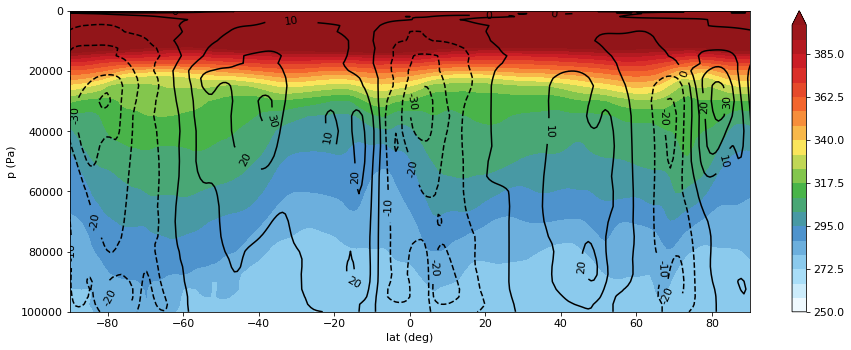

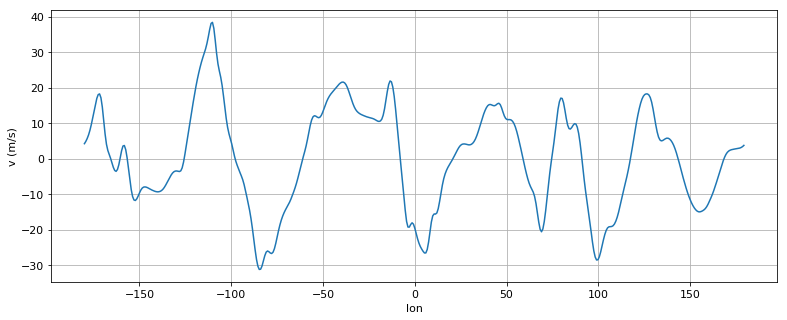

In [28]:
# Plots exercise 6.
theta_range = np.linspace(250, 400, 21)
fig1 = plt.figure()
ax1 = plt.subplot(111)
cb = ax1.contourf(lon, p, theta[:,j_lat,:], theta_range, cmap=my_cmap, extend="max")
fig1.colorbar(cb)
cl = ax1.contour(lon, p, v[:,j_lat,:], 11, colors='k', linewidths=1.5)
ax1.clabel(cl, fmt='%.0f')
ax1.invert_yaxis()
ax1.set_xlabel('lat (deg)')
ax1.set_ylabel('p (Pa)')
ax1.set_xlim(-90, 90)
ax1.set_ylim(1e5, 0)
fig1.tight_layout()

fig1 = plt.figure()
ax1 = plt.subplot(111)
ax1.plot(lon, v[n, j_lat, :])
ax1.grid()
ax1.set_xlabel('lon')
ax1.set_ylabel('v (m/s)');